<a href="https://colab.research.google.com/github/ahmadmwali/Projects/blob/main/Bayesian%20Neural%20Nets/Binary_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Neural Network

Ahmad Mustapha Wali

Group 407

In [ ]:
#Importing the relevant libraries and modules
import theano
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns
import tensorflow as tf
import theano.tensor as T
filterwarnings("ignore")
from scipy.stats import mode
floatX = theano.config.floatX
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pymc3.variational.callbacks import CheckParametersConvergence

In [ ]:
#Setting the dtype of the theano vectors to float64
floatX = theano.config.floatX

In [ ]:
#Creating a toy dataset of 1000 points, 
#and a noise factor with a standard deviation of 0.2
X,y = make_moons(noise = 0.2, random_state = 0, n_samples = 1000)

#Standardizing the dataset along the X axis
X = scale(X)

#Setting the features and labels as theano vectors of dtype float64
X = X.astype(floatX)
y = y.astype(floatX)

#Splitting the dataset into a test and train set, each of 500 samples
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.5) 

[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Toy binary classification data set')]

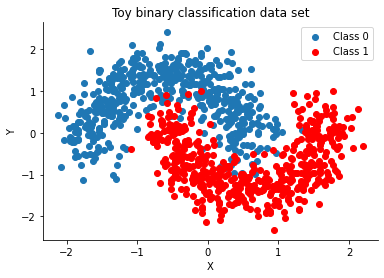

In [ ]:
#Plotting the dataset
fig, ax = plt.subplots()
ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class 0")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set")

# Bayesian Implementation

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 19.766


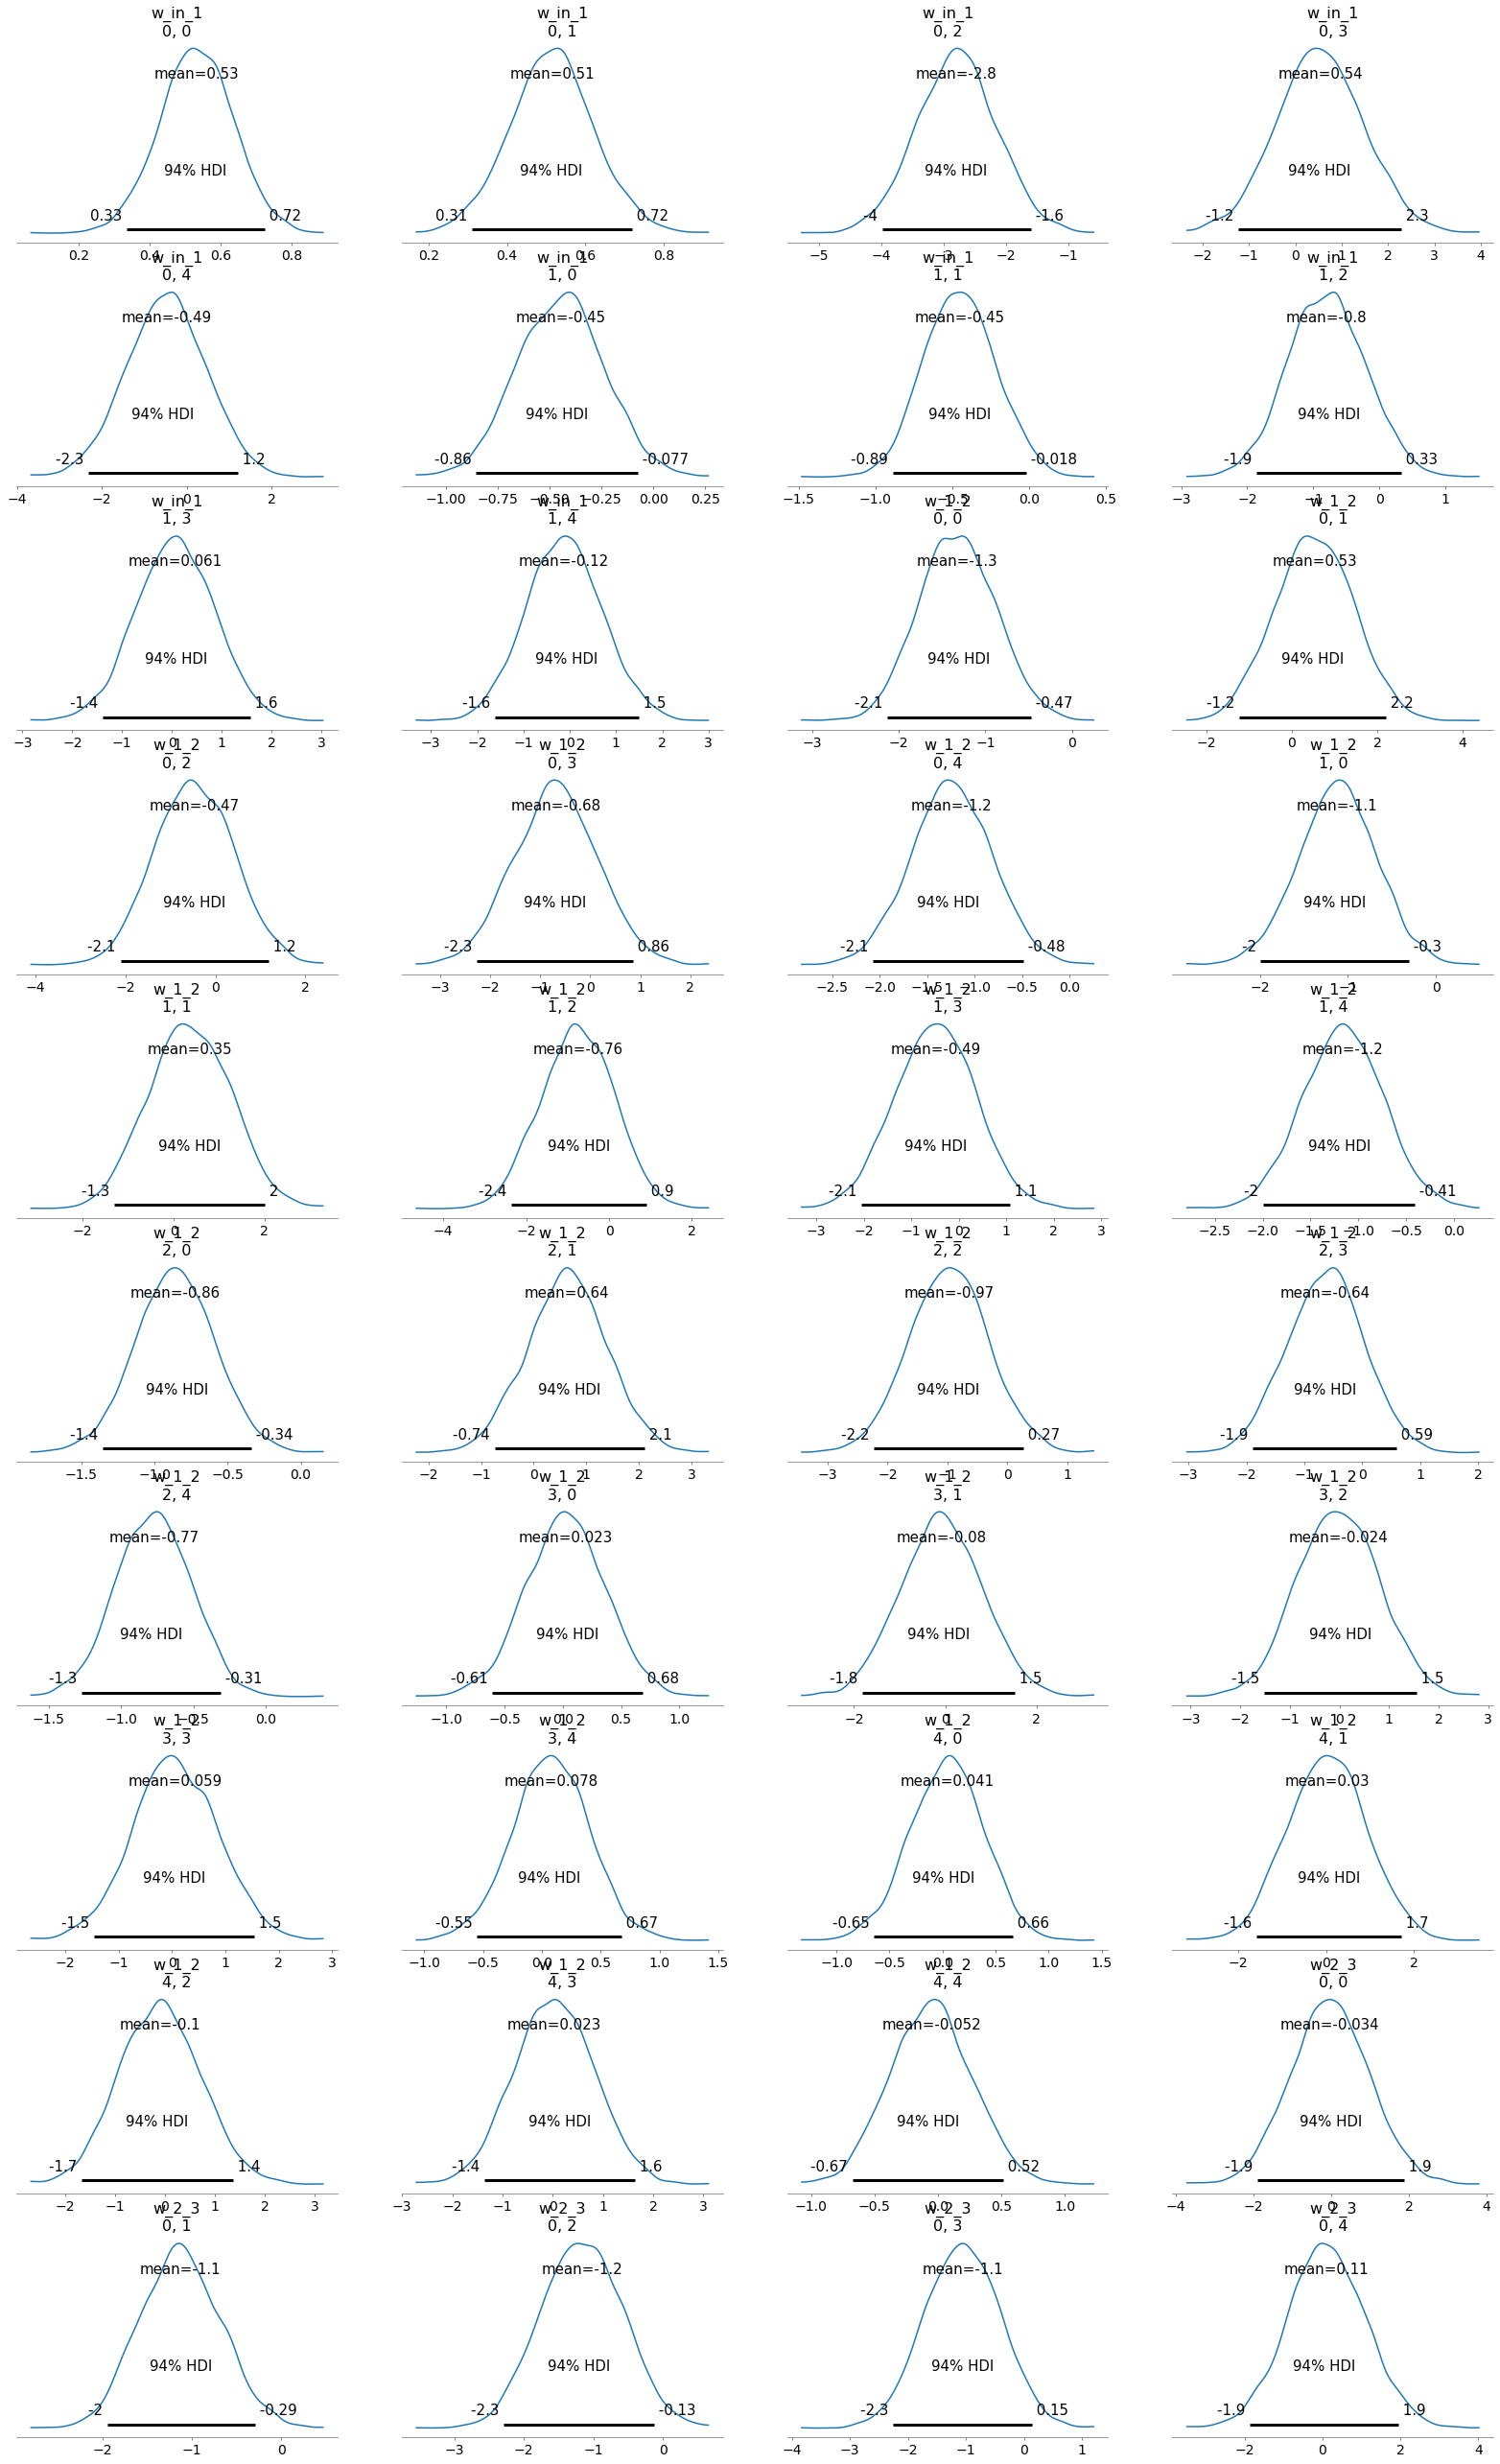

In [ ]:
    #Specifying the hidden neuron numbers
    neurons = 5

    #Initializing random weights between each layer
    init_1 = np.random.randn(X.shape[1], neurons).astype(floatX)
    init_2 = np.random.randn(neurons, neurons).astype(floatX)
    init_3 = np.random.randn(neurons, neurons).astype(floatX)
    init_out = np.random.randn(neurons).astype(floatX) 


    with pm.Model() as bayesian_neural_network:

      #Setting the inputs as shared variables
      input = pm.Data('input', X_train)
      output = pm.Data('output', Y_train)

      #Setting the priors of the weights as normal distributions
      weights_in_1 = pm.Normal("w_in_1", 0, sigma = 1, shape = (X.shape[1], neurons), testval = init_1)
      weights_1_2 = pm.Normal("w_1_2", 0, sigma = 1, shape = (neurons, neurons), testval = init_2)
      weights_2_3 = pm.Normal("w_2_3", 0, sigma = 1, shape = (neurons, neurons), testval = init_3)
      weights_3_out = pm.Normal("w_3_out", 0, sigma = 1, shape = (neurons), testval =  init_out)

      #Activation functions
      act_1 = pm.math.tanh(pm.math.dot(input, weights_in_1))
      act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
      act_3 = pm.math.tanh(pm.math.dot(act_2, weights_2_3))
      act_out = pm.math.sigmoid(pm.math.dot(act_3, weights_3_out))

      #Likelihood function as a Bernoulli variable
      out = pm.Bernoulli('out', act_out, observed = output, total_size = Y_train.shape[0])

      #Fitting and training the dataset with minibatch using an ADVI sampler 
      inference = pm.ADVI()
      X_batch = pm.Minibatch(X_train, batch_size=50)
      Y_batch = pm.Minibatch(Y_train, batch_size=50)
      
      approx = pm.fit(n=50000, method=inference, callbacks=[CheckParametersConvergence()],
                      more_replacements={input: X_batch, output: Y_batch})
      trace_advi = approx.sample(5000)
      
      '''Testing the network using the testset, and plotting the posterior weight distributions. 
      The plot function the will plot the posteriors of the weights individually.'''
      az.plot_posterior(trace_advi)
      pm.set_data(new_data={"input": X_test, "output": Y_test}, model=bayesian_neural_network)
      ppc = pm.sample_posterior_predictive(trace_advi, samples=1000, progressbar=True, model=bayesian_neural_network)

It could be observed that all the posteriors' weight distributions are normally distributed, 

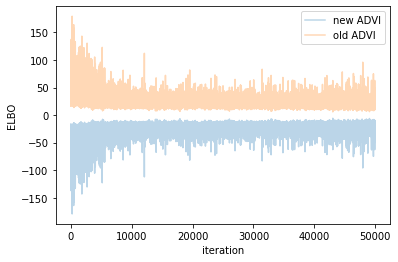

In [ ]:
#Optimization plot for evidence-based lower bound, which is the equivalent 
#of the Kullback-Leibler (KL) divergence, for the inferences.

plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

The ELBO plots show that while the approximation improved to the 10000th iteration, it kept fluctuting between 50 and 100.

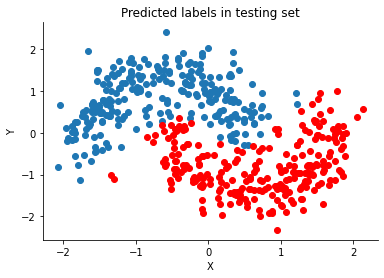

In [ ]:
'''A plot of what the model has learnt using some samples with a histogram probability distribution of the test data. 
The mode of the histogram is selected to as the predicted number.'''

fig, ax = plt.subplots()
ax.scatter(X_test[y_pred == 0, 0], X_test[y_pred == 0, 1])
ax.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1], color="r")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [ ]:
y_pred = mode(ppc["out"]).mode[0,:]
print(f"Test set accuracy: {100*accuracy_score(Y_test, y_pred)}%")

Test set accuracy: 92.80000000000001%


# Sanity Check

In this section, 2 sets of random numbers were created, then fed into the previously-created multiclass neural network. The network, however, has a fixed distribution of weights instead of a distribution of random numbers.

In [ ]:
#Creating a function for generating a set of 100 random numbers
def generate():
  X_Sanity = X = np.random.randn(100, 2)
  Y_Sanity = Y = np.tanh(X[:, 0] + X[:, 1])
  Y_Sanity = 1. / (1. + np.exp(-(Y + Y)))
  Y_Sanity = Y > 0.5

  return X_Sanity, Y_Sanity

In [ ]:
#Generating the test and training data
Sanity_X_train, Sanity_Y_train = generate()
Sanity_X_test, Sanity_Y_test = generate()

In [ ]:
#Scaling the train set along the X axis, and setting it to a float64 dtype.
Sanity_X_train = scale(Sanity_X_train)
Sanity_X_train = Sanity_X_train.astype(floatX)
Sanity_Y_train = Sanity_Y_train.astype(floatX)

In [ ]:
#Scaling the train set along the X axis, and setting it to a float64 dtype.
Sanity_X_test = scale(Sanity_X_test)
Sanity_X_test = Sanity_X_test.astype(floatX)
Sanity_Y_test = Sanity_Y_test.astype(floatX)

Finished [100%]: Average Loss = 27.291


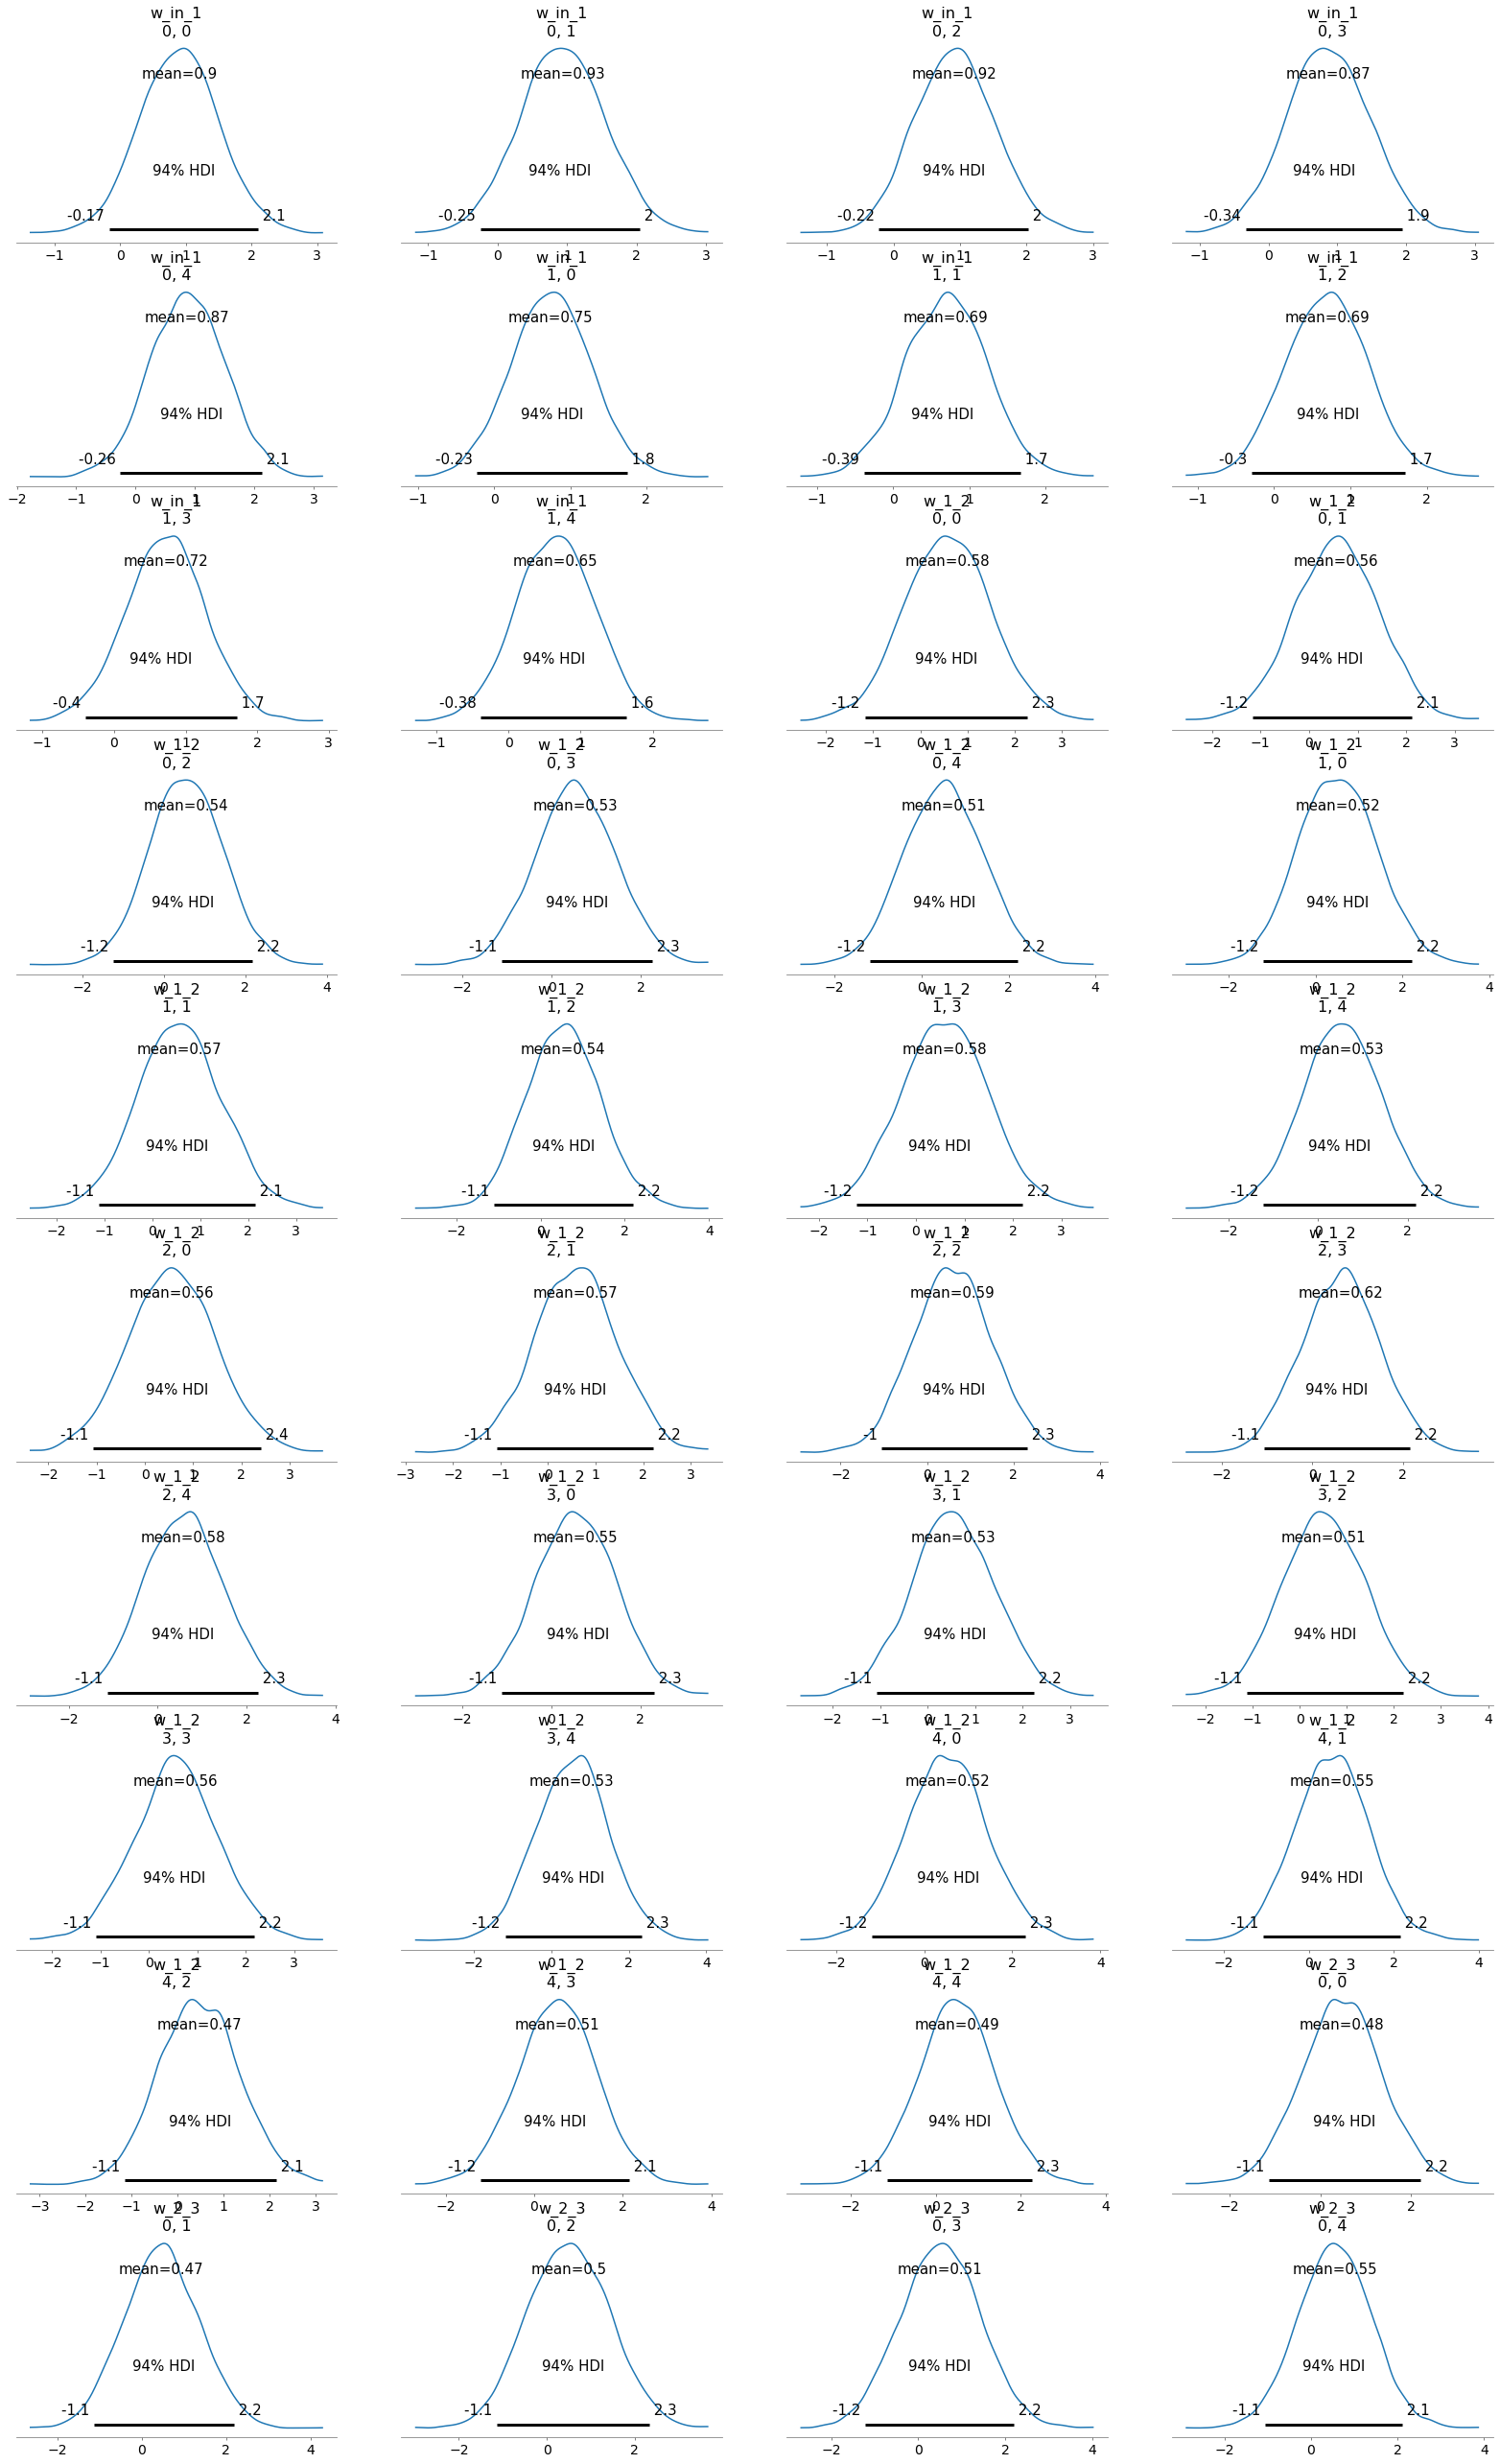

In [ ]:
    #Specifying the hidden neuron numbers
    neurons = 5
    
    #Initializing random weights between each layer and the biases
    init_1 = np.ones((X.shape[1], neurons)).astype(floatX)
    init_2 = np.ones((neurons, neurons)).astype(floatX)
    init_3 = np.ones((neurons, neurons)).astype(floatX)
    init_out = np.ones((neurons)).astype(floatX) 

    #Defining the model
    with pm.Model() as sanity_check_neural_network:
      input = pm.Data('input', Sanity_X_train)
      output = pm.Data('output', Sanity_Y_train)
      
     #Setting the inputs and outputs as shared variables
      weights_in_1 = pm.Normal("w_in_1", 0, sigma = 1, shape = (Sanity_X_train.shape[1], neurons), testval = init_1)
      weights_1_2 = pm.Normal("w_1_2", 0, sigma = 1, shape = (neurons, neurons), testval = init_2)
      weights_2_3 = pm.Normal("w_2_3", 0, sigma = 1, shape = (neurons, neurons), testval = init_3)
      weights_3_out = pm.Normal("w_3_out", 0, sigma = 1, shape = (neurons), testval =  init_out)

      #Activation functions    
      act_1 = pm.math.tanh(pm.math.dot(input, weights_in_1))
      act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
      act_3 = pm.math.tanh(pm.math.dot(act_2, weights_2_3))
      act_out = pm.math.sigmoid(pm.math.dot(act_3, weights_3_out))

      #The likelihood function set as a Bernoulli variable
      out = pm.Bernoulli('out', act_out, observed = output, total_size = Sanity_Y_train.shape[0])

      #Fitting and training the dataset with minibatch using an ADVI sampler 
      inference = pm.ADVI()
      X_batch = pm.Minibatch(Sanity_X_train, batch_size=50)
      Y_batch = pm.Minibatch(Sanity_Y_train, batch_size=50)
      approx = pm.fit(n=50000, method=inference, callbacks=[CheckParametersConvergence()], 
                      more_replacements={input: X_batch, output: Y_batch})
      
      #Traceplots of the samples   
      trace_advi = approx.sample(5000)
      az.plot_posterior(trace_advi)
      pm.set_data(new_data={"input": Sanity_X_test, "output": Sanity_Y_test}, model=sanity_check_neural_network)
      ppc = pm.sample_posterior_predictive(trace_advi, samples=1000, progressbar=True, model=sanity_check_neural_network)

The weight distributions are similar in distributions to the ones specified in the priors. Also, weights in the same layer have almost the same mean and standard deviation.

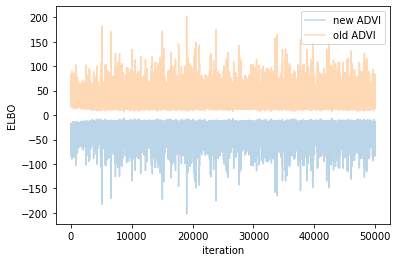

In [ ]:
#ELBO plot of the inference. It could also be noticed that it improves over time
#though not as good as the one with random weights
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

The ELBO plots show that the inferencing approximation moves rather randomly, and does not show any signs of improving or worsening.

In [ ]:
#Predicting the test set and its accuracy
Sanity_y_pred = mode(ppc["out"]).mode[0,:]
print(f"Test set accuracy: {100*accuracy_score(Sanity_Y_test, Sanity_y_pred)}%")

Test set accuracy: 79.0%


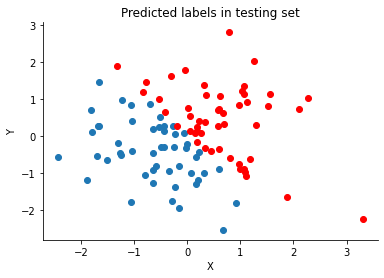

In [ ]:
#Plotting the model's prediction 
fig, ax = plt.subplots()
ax.scatter(Sanity_X_test[Sanity_y_pred == 0, 0], Sanity_X_test[Sanity_y_pred == 0, 1])
ax.scatter(Sanity_X_test[Sanity_y_pred == 1, 0], Sanity_X_test[Sanity_y_pred == 1, 1], color="r")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

# Classical Binary Neural Network

In this section, I implemented the same network architecture using Keras from TensorFlow. I used Adam optimizer for gradient descent. The model also calculates cross entropy obtained as a result of testing.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(5, activation='sigmoid')

])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
16/16 [==============================] - 0s 1ms/step - loss: 1.6585 - accuracy: 0.0340
Epoch 2/20
16/16 [==============================] - 0s 2ms/step - loss: 1.5701 - accuracy: 0.2220
Epoch 3/20
16/16 [==============================] - 0s 1ms/step - loss: 1.4839 - accuracy: 0.5340
Epoch 4/20
16/16 [==============================] - 0s 1ms/step - loss: 1.3999 - accuracy: 0.7240
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 1.3130 - accuracy: 0.7560
Epoch 6/20
16/16 [==============================] - 0s 2ms/step - loss: 1.2282 - accuracy: 0.7860
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 1.1436 - accuracy: 0.7980
Epoch 8/20
16/16 [==============================] - 0s 2ms/step - loss: 1.0622 - accuracy: 0.8080
Epoch 9/20
16/16 [==============================] - 0s 2ms/step - loss: 0.9835 - accuracy: 0.8120
Epoch 10/20
16/16 [==============================] - 0s 2ms/step - loss: 0.9103 - accuracy: 0.8180
Epoch 11/20
16/16 [

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print(f"Test set accuracy: {100*test_acc}%")

16/16 - 0s - loss: 0.4489 - accuracy: 0.8640 - 123ms/epoch - 8ms/step
Test set accuracy: 86.40000224113464%


# Observations

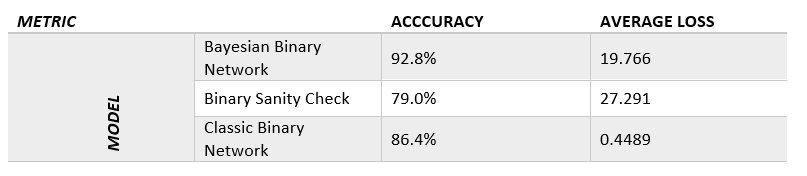

As seen in the picture, the bayesian model performed much better in terms of both accuracy and average loss than the others. Perhaps due to the rigid weights and the randomness of the test and train set, the sanity check performed the least, which is not unexpected. 